# K-mean clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

In [1]:
%matplotlib inline
import math, operator
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Create data

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action.

In [2]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In statistical parlance, we're going to simulate 1500 realizations from 6 different bivariate normal distributions (250 each) with random centroids over the range -35, 35.

In [3]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2)) #https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.uniform.html

In [4]:
slices = [np.random.multivariate_normal(centroids[i], np.diag([5.,5.]), n_samples) for i in range(n_clusters)] #https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.multivariate_normal.html
#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.diag.html

In [5]:
data = np.concatenate(slices).astype(np.float32) #https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.concatenate.html
#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.astype.html
#https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html

In [6]:
centroids

array([[ 27.66680238, -29.86351132],
       [ 30.40609027, -33.01072242],
       [-23.02681218,  -0.89862698],
       [  5.52424915,  -1.54085674],
       [-14.54454733, -23.83861444],
       [ 24.43746803,   0.38266026]])

In [7]:
len(slices), len(slices[0])

(6, 250)

In [8]:
data.shape, data[0:6]

((1500, 2), array([[ 26.90995026, -32.63692474],
        [ 29.28204727, -26.0623951 ],
        [ 26.2685833 , -29.18240738],
        [ 25.04026794, -30.66462898],
        [ 25.54991341, -30.87162399],
        [ 24.05592728, -32.46619797]], dtype=float32))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [9]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids))) #https://matplotlib.org/examples/color/colormaps_reference.html
    #https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linspace.html
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i], s=1) 
        #https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.scatter.html
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        #https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

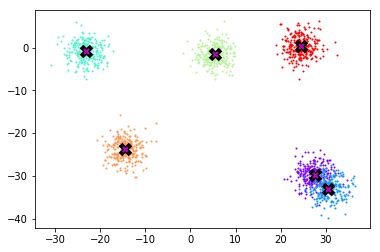

In [10]:
plot_data(centroids, data, n_samples)

## K-means

The goal of clustering is to identify these clusters, defined by their centroids, given the raw data with no labels. Once these centroids have been identified, each point is labelled as belonging to the centroid it is closest to.

K means clustering is a simple and popular approach of finding appropriate centroids. It does this by taking random centroids, and iteratively moving them to make the clusters as compact as possible.

The algorithm is very simple:
- Select the number of clusters N you want to find
- Guess N random centroids (more on this below)
- While centroids change:
    - Create clusters by assigning each point to the nearest centroid
    - For each cluster, define the new centroid as the centroid of all points assigned to it
    
Typically the algorithm is terminated once the change in centroids is negligible or after a certain number of iterations.

While guessing random centroids is fine in theory, most implementations use the data itself to identify initial cluster points. This speeds up convergence by initializing centroids in the appropriate regime. Typically, inital points are selected amongst the data and tries to pick them to be as far apart as possible.

In [45]:
import Kmeans_class_module 
from Kmeans_class_module import Kmeans
import importlib
from importlib import reload
importlib.reload(Kmeans_class_module)

<module 'Kmeans_class_module' from 'C:\\Users\\Gavrilov\\My Projects\\Kmeans\\Kmeans_class_module.py'>

In [46]:
k = Kmeans(data, n_clusters)

In [47]:
sess = tf.InteractiveSession() #https://www.tensorflow.org/api_docs/python/tf/InteractiveSession
#interactive session basically means that you don't have to worry about creating a graph or a session or having a session with clause.
#so, by creating an interactive session, we can kind of do things one step at a time.

Basic algorithm for initial centroids search;
instead of picking them randomly it is better to use heuristics for picking them

It looks a lot like in NumPy, except in places you would expect to see np we see tf; 
besides, in TensorFlow, pretty much everything takes and returns a tensor

In [117]:
#function to calculate every distance between every element of a and every element of b
def all_distances(a, b):
    #tensors broadcasting: a and b are one dimensional vectors, so it has no concept of what direction it's looking, it is now a row vector
    diff = tf.squared_difference(tf.expand_dims(a, 0), tf.expand_dims(b,1)) 
    #https://www.tensorflow.org/api_docs/python/tf/expand_dims -for the a tensor we add an additional axis to axis 0
    #for the b tensor we add additional axis to axis 1, so it is now definately column vector
    #we end up with a matrix containing the difference between vectors (a row and b column?)
    #https://www.tensorflow.org/api_docs/python/tf/squared_difference -we can call a squared_difference
    return tf.reduce_sum(diff, axis=2) #https://www.tensorflow.org/api_docs/python/tf/reduce_sum -we can sum over the last axis, so the last axis is the dimensions

In [156]:
def find_initial_centroids(k):
    #data was sent in as a NumPy array and then we called tf.Variable on it
    #the data is now basically copied to the GPU
    #copying occurs when you write tf.global_variales_initializer().run()
    v_data = tf.Variable(data) #https://www.tensorflow.org/api_docs/python/tf/Variable
    n_data, n_dim = data.shape
    #first of all we pick a single datapoint index by finding random number
    #we choose integer type because we trying to get random index, its going to be between zero and number data points we have
    r_index = tf.random_uniform([1], 0, n_data, dtype=tf.int32) #https://www.tensorflow.org/api_docs/python/tf/random_uniform
    #then we select that single datapoint
    #we can go ahead and index into our data
    r = tf.expand_dims(v_data[tf.squeeze(r_index)], dim=1) 
    #https://www.tensorflow.org/api_docs/python/tf/squeeze is for turning tensor into scalar, 
    #because then we're just indexing into here to get a single item back.
    #https://www.tensorflow.org/api_docs/python/tf/expand_dims is for expanding scalar back again into a tensor,
    #because inside our loop this is going to be a list of initial centroids
    initial_centroids = []
    #instead of standart Python loop we can use more serious performance tf tricks like below
    #https://www.tensorflow.org/api_docs/python/tf/while_loop
    #https://www.tensorflow.org/api_docs/python/tf/scan
    #https://www.tensorflow.org/api_docs/python/tf/map_fn
    for i in range(k):
        #then we find what is the distance from that randomly selected datapoint to every other datapoint
        dist = all_distances(v_data, r)
        #then we look, what is the datapoint (index) that is the furthest away from that randomly selected datapoint
        farthest_index = tf.argmax(tf.reduce_min(dist, axis=0), 0)  
        #https://www.tensorflow.org/api_docs/python/tf/reduce_min -when we go reduce_min with axis 0, we finding out for every point, 
        #ow far away is it from its nearest initial centroid
        #https://www.tensorflow.org/api_docs/python/tf/argmax -to find out index of the point which is furthest away
        #then we look what at is the datapoint (point itself) that is the furthest away 
        farthest_point = v_data[tf.to_int32(farthest_index)]  
        #then we're going to append that to the initial centroids
        initial_centroids.append(farthest_point)
        #first iteration inside the loop set our random point
        #every new iteration we replace previous centroid with the actual
        r = tf.stack(initial_centroids) #https://www.tensorflow.org/api_docs/python/tf/stack -stacking together initial centroids to create a tensor of them
    return r
#important to remember that when we run this code, nothing happens other than that it creates a computation graph
#we can now must call .eval() 

In [157]:
initial_centroids = find_initial_centroids(n_clusters)

In [158]:
initial_centroids

<tf.Tensor 'stack_145:0' shape=(6, 2) dtype=float32>

Interactive session methods

In [159]:
tf.global_variables_initializer().run()#you can call .run on a computation graph which doesn't return something

In [160]:
#because we're in an interactive session we can now call .eval() 
initial_centroids.eval() # .eval() on a computation graph which does return something
#it copies it off the GPU and puts it back into the CPU as a Numpy array

array([[ 34.1779213 , -38.86890411],
       [-29.37266731,   2.51355171],
       [ 19.76370621,   5.6043458 ],
       [-11.94545078, -30.16659355],
       [ -1.57055295,  -1.34990346],
       [ 23.27980232, -23.42946815]], dtype=float32)

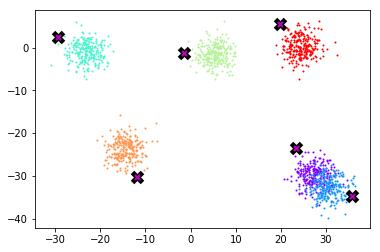

In [161]:
plot_data(initial_centroids.eval(), data, n_samples) #initial_centroids.eval() because we want to convert back from tensor to numpy array
#which we can do by simply running .eval() on the transformed tensor